In [1]:
import pandas as pd
import pickle
import networkx as nx
import sys
import os
import numpy as np

# Structural

In [2]:

sys.path.append(os.path.abspath('..'))
from src.features import get_pagerank, get_approx_betweenness, get_clustering_coefficient, get_harmonic_centrality

from src import load_or_compute

# 1. Load the graph from the pickle file
# Make sure the path is correct relative to where you run this script
with open("../data/processed/amazon_graph.pickle", "rb") as f:
    G_loaded = pickle.load(f)

recompute = False

In [3]:
df_handpagerank = load_or_compute("../data/processed/pagerank_scores.csv", get_pagerank , True , G = G_loaded, force_cpu = False)
# Now all functions (build_index_map, calculate_pagerank, etc.) are available in memory
#prscores = get_prscores(G_loaded)
display(sum(df_handpagerank["pagerank"].values))
#df_handpagerank = pd.DataFrame(list(prscores.items()), columns=['ASIN', 'MyHandPageRank'])
display(df_handpagerank.head(20))
# Save to CSV
#df_handpagerank.to_csv("../data/processed/handpagerank_scores.csv", index=False)

Computing
cpu
Saving to {file_path}...


NameError: name 'operation_type' is not defined

In [ ]:


df_bet = load_or_compute("../data/processed/bet_scores.csv",get_approx_betweenness,recompute,G=G_loaded,k=1000) 
display(df_bet.head(5))
# Save to CSV



# Now you can use the scores
print(f"Computed bet cent for {len(df_bet)} nodes.")

File found.


,Betweenness
ASIN,
0827229534,0.0
0738700797,0.0
0842328327,0.0
1577943082,0.0
0486220125,0.0


Computed bet cent for 334843 nodes.


In [ ]:


df_clus = load_or_compute("../data/processed/clus_scores.csv",get_clustering_coefficient,recompute,G = G_loaded)
display(df_clus.head(5))

# Now you can use the scores
print(f"Computed cc for {len(df_bet)} nodes.")

File found.


,ClusteringCoefficient
ASIN,
0827229534,0.136364
0738700797,0.241758
0842328327,0.333333
1577943082,0.450000
0486220125,0.250000


Computed cc for 334843 nodes.


In [ ]:
# Compute Harmonic scores and save them to a csv file
df_harmonic_scores = load_or_compute("../data/processed/harm_scores.csv",get_harmonic_centrality,recompute,G= G_loaded, version="GPU")
#df_harmonic_scores.to_csv("../data/processed/harm_scores.csv", index=False)

display(df_harmonic_scores.head(5))
print(f"Computed hc for {len(df_harmonic_scores)} nodes.")

### Now we work on df


In [ ]:

#df_pagerank = pd.DataFrame.from_dict(pagerank_scores, orient='index', columns=['PageRank'])
#df_clus = pd.DataFrame.from_dict(clus_scores, orient='index', columns=['ClusteringCoeff'])
#df_bet = pd.DataFrame.from_dict(bet_scores, orient='index', columns=['Betweenness'])


data_frames = [df_handpagerank,df_clus,df_bet,df_harmonic_scores]

df_final = pd.concat(data_frames,axis=1)

In [ ]:

salesrank_dict = nx.get_node_attributes(G_loaded, 'salesrank')

# 2. Convert to DataFrame
df_salesrank = pd.DataFrame.from_dict(salesrank_dict, orient='index', columns=['salesrank'])
df_salesrank.index.name = 'ASIN'

# 3. Join to df_final
# This performs a left join on the index (ASIN)
df_final = df_final.join(df_salesrank)

# Check the result
display(df_final.head())

,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank
ASIN,,,,,
0827229534,5.332977e-06,0.136364,0.0,10890.978000,396585.0
0738700797,9.438284e-06,0.241758,0.0,9056.977000,168596.0
0842328327,6.925232e-07,0.333333,0.0,2.840921,631289.0
1577943082,1.400741e-06,0.450000,0.0,5.111011,455160.0
0486220125,4.671820e-07,0.250000,0.0,0.000000,188784.0


In [ ]:
df_final.to_csv("../data/processed/structural_metrics.csv")

## Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Salesrank is a node attribute, while the other scores are metrics computed from the graph structure
# Then we will transform salesrank into a logarithmic scale (log(1+x) to avoid log0 issues)
df_final['salesrank_log'] = np.log1p(df_final['salesrank'])
features = ['pagerank','Betweenness','ClusteringCoefficient','HarmonicCentrality','salesrank_log']
X=df_final[features]

#non ci dovrebbero essere NaN ma per sicurezza
X=X.fillna(0)

In [ ]:
X.head()

,pagerank,Betweenness,ClusteringCoefficient,HarmonicCentrality,salesrank_log
ASIN,,,,,
0827229534,5.332977e-06,0.0,0.136364,10890.978000,12.890648
0738700797,9.438284e-06,0.0,0.241758,9056.977000,12.035267
0842328327,6.925232e-07,0.0,0.333333,2.840921,13.355521
1577943082,1.400741e-06,0.0,0.450000,5.111011,13.028406
0486220125,4.671820e-07,0.0,0.250000,0.000000,12.148364


Standardize

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=features) # to check mean and variance of std data

kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(X_scaled)

df_final['cluster_kmeans']= clusters

#questo stampa quanti nodi per ogni gruppo
print(df_final['cluster_kmeans'].value_counts())

#maybe we can save it

cluster_kmeans
0    171362
1     87227
2     71757
3      4497
Name: count, dtype: int64


In [13]:
print("Mean of scaled structural features:")
print(df_scaled.mean())
print("Std of scaled structural features:")
print(df_scaled.std())

Mean of scaled structural features:
pagerank                 4.753319e-18
Betweenness             -1.714590e-17
ClusteringCoefficient    1.570293e-17
HarmonicCentrality      -2.003185e-17
salesrank_log           -3.297615e-16
dtype: float64
Std of scaled structural features:
pagerank                 1.000001
Betweenness              1.000001
ClusteringCoefficient    1.000001
HarmonicCentrality       1.000001
salesrank_log            1.000001
dtype: float64


confronto con gruppi 

In [14]:
#aggiungo il gruppo 
groups_dict = nx.get_node_attributes(G_loaded, 'group')

# 2. Converti in un DataFrame (assicurandoti che l'indice sia l'ASIN)
df_groups = pd.DataFrame.from_dict(groups_dict, orient='index', columns=['group'])
df_groups.index.name = 'ASIN'

# 3. Unisci al tuo df_final
# Remove 'group' from node attributes if it exists to avoid conflict
if 'group' in df_final.columns:
    df_final = df_final.drop(columns=['group'])

# join è intelligente: allinea automaticamente gli indici (ASIN)
df_final = df_final.join(df_groups)

In [15]:
import seaborn as sns 
import matplotlib.pyplot as plt

crosstab = pd.crosstab(df_final['cluster_kmeans'], df_final['group'])

print(crosstab)

group             Book   DVD  Music  Video
cluster_kmeans                            
0               121335  8542  31919   9566
1                67109  4850  13870   1398
2                56893  1990   8531   4343
3                 3579   361    504     53


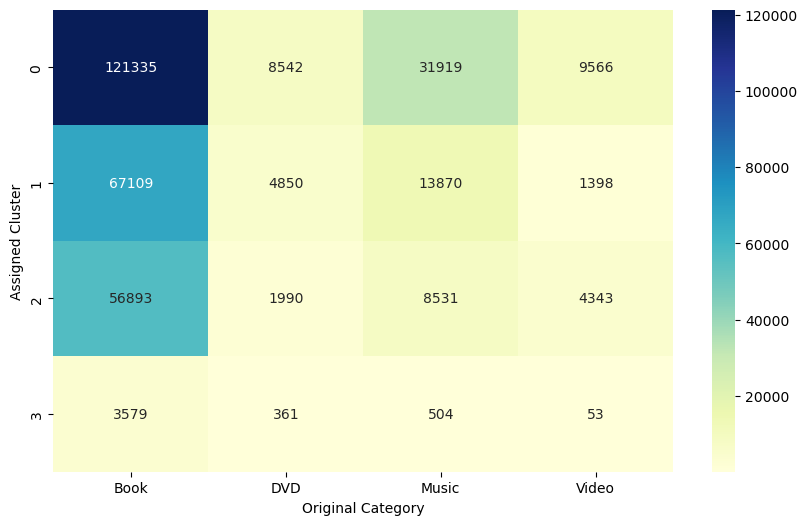

In [16]:
plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu')
plt.xlabel('Original Category')
plt.ylabel('Assigned Cluster')
plt.show()

# Embeddings 

TODO: call load or compute or a similar function
load the embeddings in a df

In [17]:
embedding_file_path = "../data/processed/embeddings_p1_q1.csv" 
df_embeddings = pd.read_csv(embedding_file_path, index_col=0)

print("embedding dimension:", df_embeddings.shape)
display(df_embeddings.head())


embedding dimension: (334843, 128)


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
ASIN,,,,,,,,,,,,,,,,,,,,,
0827229534,0.260055,0.232645,-0.184927,-0.040115,-0.278143,0.059239,0.249093,-0.193452,0.161631,0.455275,...,-0.407851,0.064328,-0.424272,-0.439670,-0.532193,0.167892,0.095325,-0.043960,0.169427,-0.179023
0738700797,0.049899,-0.159196,0.180727,0.097053,0.023940,0.016001,-0.295938,0.110715,-0.445624,0.064126,...,0.377620,0.180432,-0.135800,-0.003625,0.010143,0.175631,0.005909,0.225378,0.585375,0.041105
0842328327,0.123363,0.018838,0.117249,0.090571,0.173956,0.237264,-0.204930,0.072053,0.279451,-0.124804,...,-0.099146,0.021840,-0.157903,-0.259677,0.195515,-0.013732,0.028586,0.314114,-0.116233,-0.175825
1577943082,-0.413496,-0.197333,0.060459,0.172710,-0.365341,-0.348367,-0.037548,-0.126640,-0.236015,-0.197226,...,-0.090751,-0.363752,0.191269,0.363471,0.061586,-0.110700,-0.189879,-0.267007,-0.342396,0.384865
0486220125,0.058851,0.028835,-0.191742,0.042702,-0.062521,0.249268,0.062648,-0.057471,-0.121797,-0.084208,...,-0.042611,0.044409,-0.079390,-0.055101,0.202036,-0.216879,0.109211,-0.059634,0.028873,0.224192


In [18]:
from sklearn.preprocessing import StandardScaler, normalize

X = df_embeddings.values

X_norm = normalize(X) 

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_norm)

df_embeddings['cluster_kmeans'] = clusters

print("\nCount of clusters:")
print(df_embeddings['cluster_kmeans'].value_counts())




Count of clusters:
cluster_kmeans
3    142383
2     68132
1     66036
0     58292
Name: count, dtype: int64


In [19]:
df_final = df_final.join(df_embeddings['cluster_kmeans'], rsuffix='_emb')
df_final.head()

,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank,salesrank_log,cluster_kmeans,group,cluster_kmeans_emb
ASIN,,,,,,,,,
0827229534,5.332977e-06,0.136364,0.0,10890.978000,396585.0,12.890648,1,Book,0
0738700797,9.438284e-06,0.241758,0.0,9056.977000,168596.0,12.035267,1,Book,3
0842328327,6.925232e-07,0.333333,0.0,2.840921,631289.0,13.355521,2,Book,2
1577943082,1.400741e-06,0.450000,0.0,5.111011,455160.0,13.028406,2,Book,3
0486220125,4.671820e-07,0.250000,0.0,0.000000,188784.0,12.148364,0,Book,3


In [20]:
crosstab = pd.crosstab(df_final['cluster_kmeans_emb'], df_final['group'])

print(crosstab)

group                 Book   DVD  Music  Video
cluster_kmeans_emb                            
0                    53179   875   3009   1229
1                    25476  8909  24383   7268
2                    60563  1128   4918   1523
3                   109698  4831  22514   5340


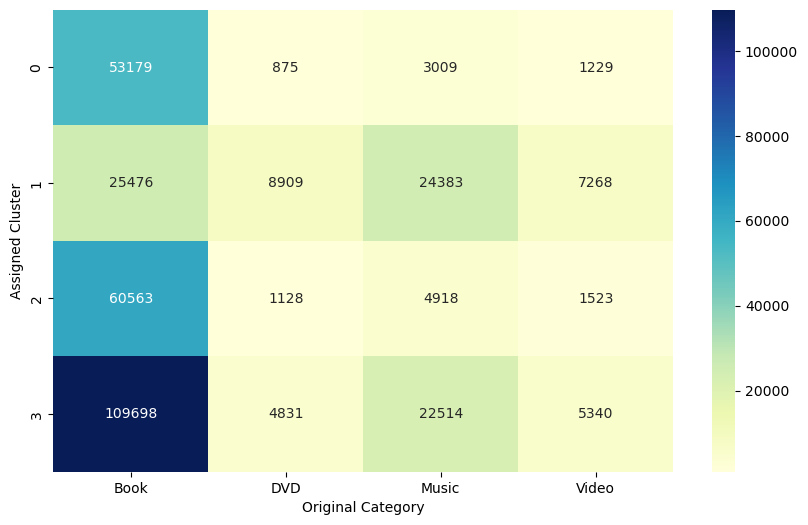

In [21]:
plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu')
plt.xlabel('Original Category')
plt.ylabel('Assigned Cluster')
plt.show()

## Hybrid


In [22]:
# 1. Upload structural features + salesrank

# Use again salsrank in logarithmic scale
df_salesrank['salesrank_log'] = np.log1p(df_salesrank['salesrank'])

data_frames = [df_handpagerank,df_clus,df_bet,df_harmonic_scores,df_salesrank[['salesrank_log']]]

df_struct = pd.concat(data_frames,axis=1)
df_struct.head()

,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank_log
ASIN,,,,,
0827229534,5.332977e-06,0.136364,0.0,10890.978000,12.890648
0738700797,9.438284e-06,0.241758,0.0,9056.977000,12.035267
0842328327,6.925232e-07,0.333333,0.0,2.840921,13.355521
1577943082,1.400741e-06,0.450000,0.0,5.111011,13.028406
0486220125,4.671820e-07,0.250000,0.0,0.000000,12.148364


In [23]:
# 2. Upload learned features (embeddings) and align with structural features
df_emb = pd.read_csv("../data/processed/embeddings_p1_q1.csv", index_col=0)

df_hybrid_raw = df_struct.join(df_emb, how='inner', lsuffix='_struct', rsuffix='_emb')

# Identify columns
cols_struct = [c for c in df_struct.columns if c not in ['group', 'title', 'ASIN', 'salesrank']]
cols_emb = [c for c in df_emb.columns if c not in ['group', 'title', 'ASIN']]

print(f"Structural features (Centralità + Salesrank_log): {len(cols_struct)}")
print(f"Embedding dimensions: {len(cols_emb)}")
print(f"Total aligned nodes: {len(df_hybrid_raw)}")

Structural features (Centralità + Salesrank_log): 5
Embedding dimensions: 128
Total aligned nodes: 334843


In [24]:
# 3. Normalization

# Standardize structural features (Z-score)
scaler = StandardScaler()
X_struct_scaled = scaler.fit_transform(df_hybrid_raw[cols_struct].fillna(0))

# Normalize embedding features (L2 norm)
X_emb_norm = normalize(df_hybrid_raw[cols_emb].fillna(0))

# Compute weight
lambda_weight = np.sqrt(len(cols_emb) / len(cols_struct))

# Combine features
X_struct_weighted = X_struct_scaled * lambda_weight
X_hybrid_balanced = np.hstack((X_struct_weighted, X_emb_norm))

In [25]:
#ho ricaricaricato gli embeddings ma si puo usare il df di prima 
df_emb = pd.read_csv("../data/processed/embeddings_p1_q1.csv", index_col=0)

In [26]:
# Create final DataFrame
df_hybrid_features = pd.DataFrame(
    X_hybrid_balanced, 
    index=df_hybrid_raw.index, 
    columns=list(cols_struct) + list(cols_emb)
)

display(df_hybrid_features.head())

,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank_log,emb_0,emb_1,emb_2,emb_3,emb_4,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
ASIN,,,,,,,,,,,,,,,,,,,,,
0827229534,1.720197,-1.753464,-0.536424,10.337586,3.553449,0.096978,0.086756,-0.068962,-0.014959,-0.103723,...,-0.152093,0.023989,-0.158216,-0.163959,-0.198462,0.062609,0.035548,-0.016393,0.063182,-0.066760
0738700797,4.675005,0.943836,-0.536424,8.081389,0.661464,0.016927,-0.054004,0.061308,0.032923,0.008121,...,0.128100,0.061208,-0.046068,-0.001230,0.003441,0.059579,0.002005,0.076455,0.198577,0.013944
0842328327,-1.619784,3.287463,-0.536424,-3.057052,5.125149,0.074597,0.011391,0.070899,0.054768,0.105190,...,-0.059953,0.013206,-0.095483,-0.157024,0.118226,-0.008304,0.017286,0.189942,-0.070285,-0.106320
1577943082,-1.110042,6.273242,-0.536424,-3.054260,4.019200,-0.176245,-0.084110,0.025770,0.073615,-0.155720,...,-0.038681,-0.155043,0.081525,0.154923,0.026250,-0.047184,-0.080933,-0.113807,-0.145940,0.164042
0486220125,-1.781975,1.154763,-0.536424,-3.060547,1.043839,0.033620,0.016473,-0.109536,0.024394,-0.035716,...,-0.024342,0.025369,-0.045353,-0.031477,0.115417,-0.123896,0.062389,-0.034067,0.016494,0.128074


In [27]:
print("Mean of scaled structural features:")
print(df_hybrid_features[cols_struct].mean())
print("Std of scaled structural features:")
print(df_hybrid_features[cols_struct].std())

Mean of scaled structural features:
pagerank                -8.963402e-17
ClusteringCoefficient    2.040532e-16
Betweenness              4.889129e-17
HarmonicCentrality      -1.697614e-16
salesrank_log           -1.670452e-15
dtype: float64
Std of scaled structural features:
pagerank                 5.059652
ClusteringCoefficient    5.059652
Betweenness              5.059652
HarmonicCentrality       5.059652
salesrank_log            5.059652
dtype: float64


In [28]:

# 4. Clustering K-Means

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_hybrid_features)

# 5. Analysis of results

# Aggiungiamo i cluster al df originale per analisi
#df_results = df_hybrid_raw.copy()
df_final.loc[df_hybrid_raw.index, 'cluster_hybrid'] = clusters

# Se hai la colonna 'group' (ground truth), analizza i risultati
if 'group' in df_final.columns:
    print("\nComparison with Ground Truth:")
    print(pd.crosstab(df_final['cluster_hybrid'], df_final['group']))


Comparison with Ground Truth:
group             Book   DVD  Music  Video
cluster_hybrid                            
0.0             121339  8543  31920   9567
1.0               3579   361    504     53
2.0              56889  1989   8530   4342
3.0              67109  4850  13870   1398


In [29]:
df_final.head()

,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank,salesrank_log,cluster_kmeans,group,cluster_kmeans_emb,cluster_hybrid
ASIN,,,,,,,,,,
0827229534,5.332977e-06,0.136364,0.0,10890.978000,396585.0,12.890648,1,Book,0,3.0
0738700797,9.438284e-06,0.241758,0.0,9056.977000,168596.0,12.035267,1,Book,3,3.0
0842328327,6.925232e-07,0.333333,0.0,2.840921,631289.0,13.355521,2,Book,2,2.0
1577943082,1.400741e-06,0.450000,0.0,5.111011,455160.0,13.028406,2,Book,3,2.0
0486220125,4.671820e-07,0.250000,0.0,0.000000,188784.0,12.148364,0,Book,3,0.0


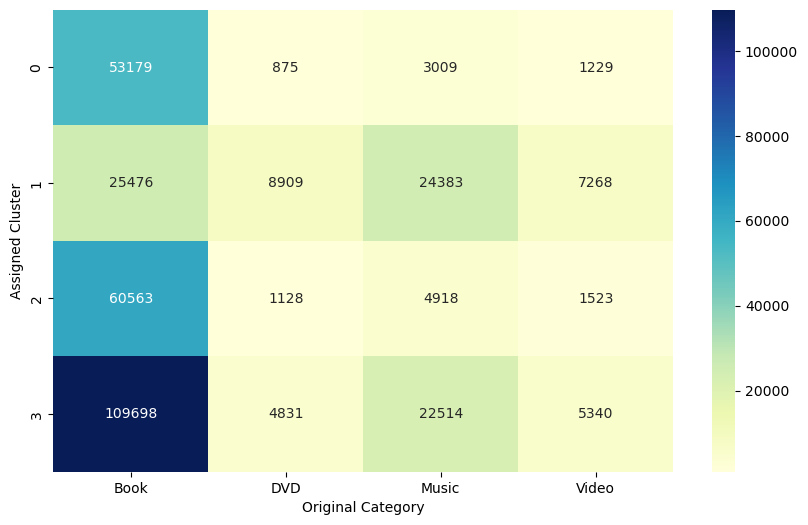

In [30]:
plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu')
plt.xlabel('Original Category')
plt.ylabel('Assigned Cluster')
plt.show()

# Normalized Mutual Information (NMI)

## A. Structural Features

In [36]:
import os
import pandas as pd
from datetime import datetime

RESULTS_FILE = "../data/results/clustering_results.csv"

def log_clustering_results(method_name, nmi):
    """
    Save clustering evaluation results to a CSV file.
    Args:
        method_name (str): Name of the clustering method.
        nmi (float): Normalized Mutual Information score.
    """
    new_entry = pd.DataFrame([{
        'method': method_name, 
        'NMI': round(nmi, 4)
    }])

    if not os.path.exists(RESULTS_FILE):
        os.makedirs(os.path.dirname(RESULTS_FILE), exist_ok=True)
        new_entry.to_csv(RESULTS_FILE, index=False)
    else:
        new_entry.to_csv(RESULTS_FILE, mode='a', header=False, index=False)

    print(f"Clustering results for {method_name} saved corrctly.")

In [37]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

df_eval_struct = df_final.dropna(subset=['group', 'cluster_kmeans'])

nmi_struct = normalized_mutual_info_score(df_eval_struct['group'], df_eval_struct['cluster_kmeans'])

print(f"Normalized Mutual Information (NMI): {nmi_struct:.4f}")

log_clustering_results("Structural + Salesrank", nmi_struct)

Normalized Mutual Information (NMI): 0.0098
Clustering results for Structural + Salesrank saved corrctly.


## B. Learned Features

In [38]:
df_eval_emb = df_final.dropna(subset=['group', 'cluster_kmeans_emb'])

nmi_emb = normalized_mutual_info_score(df_eval_emb['group'], df_eval_emb['cluster_kmeans_emb'])

print(f"Normalized Mutual Information (NMI): {nmi_emb:.4f}")

log_clustering_results("Learned (Embeddings)", nmi_emb)

Normalized Mutual Information (NMI): 0.0829
Clustering results for Learned (Embeddings) saved corrctly.


## C. Hybrid Features

In [39]:

df_eval_hybrid = df_final.dropna(subset=['group', 'cluster_hybrid'])

nmi_hybrid = normalized_mutual_info_score(df_eval_hybrid['group'], df_eval_hybrid['cluster_hybrid'])

print(f"Normalized Mutual Information (NMI): {nmi_hybrid:.4f}")

log_clustering_results("Hybrid (Balanced)", nmi_hybrid)

Normalized Mutual Information (NMI): 0.0098
Clustering results for Hybrid (Balanced) saved corrctly.


SUMMARY:


,NMI
method,
Learned (Embeddings),0.0829
Hybrid (Balanced),0.0098
Structural + Salesrank,0.0098


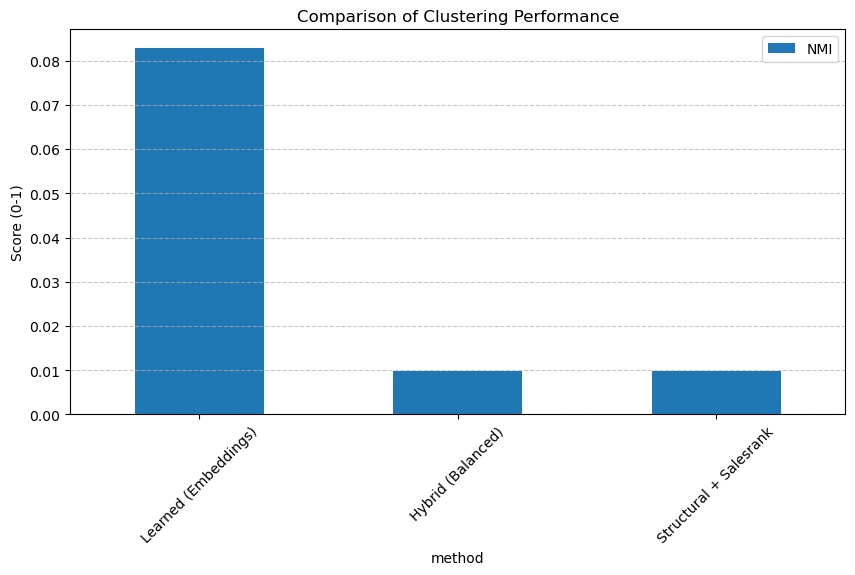

In [40]:
# Upload results
df_results = pd.read_csv(RESULTS_FILE)

# Group them by
summary = df_results.groupby('method')[['NMI']].last().sort_values('NMI', ascending=False)

# Print table for comparisons
print("SUMMARY:")
display(summary)

# Plot
summary.plot(kind='bar', figsize=(10, 5))
plt.title("Comparison of Clustering Performance")
plt.ylabel("Score (0-1)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Original Categories plotting

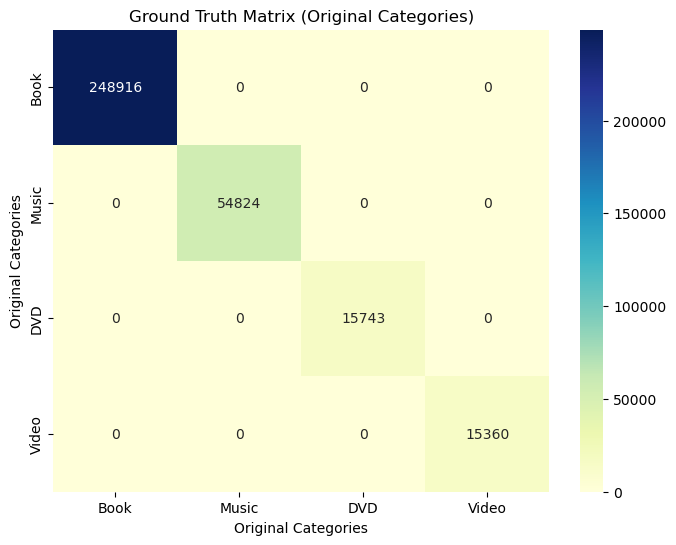

In [41]:
# Original clustering
# Print the original clustering figure

# Extract ground truth groups from the graph
groups_dict = nx.get_node_attributes(G_loaded, 'group')
groups_series = pd.Series(groups_dict)

# Count occurrences of each category
counts = groups_series.value_counts()
categories = counts.index.tolist()

# Make an empty confusion matrix
gt_matrix = pd.DataFrame(0, index=categories, columns=categories)

# Fill the diagonal with the real counts
for cat in categories:
    gt_matrix.loc[cat, cat] = counts[cat]

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(gt_matrix, annot=True, fmt='d', cmap='YlGnBu')

plt.title('Ground Truth Matrix (Original Categories)')
plt.xlabel('Original Categories')
plt.ylabel('Original Categories')
plt.show()